In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from tensorflow.examples.tutorials.mnist import input_data 
np.random.seed(20160612) 
tf.set_random_seed(20160612)
#데이터 불러오기
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
#ensemble 모델을 위한 클래스 지정

class model:
  
  global_step = tf.Variable(0, trainable=False)
  starter_learning_rate = 0.0005
  learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
            20000, 0.96, staircase=True)
  is_train = tf.placeholder(tf.bool, name='phase')
  keep_prob_dense = tf.placeholder(tf.float32)
  keep_prob_conv = tf.placeholder(tf.float32)
  num_filters1 = 32
  x = tf.placeholder(tf.float32, [None, 784])
  x_image = tf.reshape(x, [-1,28,28,1])
  #hidden convolutional layer
  W_conv1 = tf.Variable(tf.truncated_normal([3,3,1,num_filters1], stddev=0.1))
  h_conv1 = tf.nn.conv2d(x_image, W_conv1, strides=[1,1,1,1], padding='SAME')
  b_conv1 = tf.Variable(tf.constant(0.1, shape=[num_filters1]))
  h_conv1_batchnorm=tf.layers.batch_normalization(h_conv1+b_conv1,training=is_train)
  h_conv1_cutoff = tf.nn.relu(h_conv1_batchnorm)
  h_pool1 = tf.nn.max_pool(h_conv1_cutoff, ksize=[1,2,2,1],
  strides=[1,2,2,1], padding='SAME')
  #hidden convolutional layer
  num_filters2 = 64
  W_conv2 = tf.Variable(
  tf.truncated_normal([3,3,num_filters1,num_filters2], stddev=0.1))
  h_conv2 = tf.nn.conv2d(h_pool1, W_conv2,
  strides=[1,1,1,1], padding='SAME')
  b_conv2 = tf.Variable(tf.constant(0.1, shape=[num_filters2]))
  h_conv2_batch_norm=tf.layers.batch_normalization(h_conv2+b_conv2, training=is_train)
  h_conv2_cutoff = tf.nn.relu(h_conv2_batch_norm)
  h_pool2 = tf.nn.max_pool(h_conv2_cutoff, ksize=[1,2,2,1],
  strides=[1,2,2,1], padding='SAME')
  #hidden convolutional layer
  num_filters3 = 128
  W_conv3 = tf.Variable(
  tf.truncated_normal([3,3,num_filters2,num_filters3], stddev=0.1))
  h_conv3 = tf.nn.conv2d(h_pool2, W_conv3,
  strides=[1,1,1,1], padding='SAME')
  b_conv3= tf.Variable(tf.constant(0.1, shape=[num_filters3]))
  h_conv3_batch_norm=tf.layers.batch_normalization(h_conv3+b_conv3, training=is_train)
  h_conv3_cutoff = tf.nn.relu(h_conv3_batch_norm)
  h_pool3 = tf.nn.max_pool(h_conv3_cutoff, ksize=[1,2,2,1],
  strides=[1,1,1,1], padding='SAME')
  #dense layer
  h_pool2_flat = tf.reshape(h_pool3, [-1, 7*7*num_filters3])
  num_units1 = 7*7*num_filters3
  num_units2 = 1024
  w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
  b2 = tf.Variable(tf.constant(0.1, shape=[num_units2]))
  hidden2_batch_norm=tf.layers.batch_normalization(tf.matmul(h_pool2_flat, w2) + b2, training=is_train)
  hidden2 = tf.nn.relu(hidden2_batch_norm)
  keep_prob = tf.placeholder(tf.float32)
  hidden2_drop = tf.nn.dropout(hidden2, keep_prob)
  w0 = tf.Variable(tf.zeros([num_units2, 10]))
  b0 = tf.Variable(tf.zeros([10]))
  p = tf.nn.softmax(tf.matmul(hidden2_drop, w0) + b0)
  t = tf.placeholder(tf.float32, [None, 10])
  loss = -tf.reduce_sum(t * tf.log(p))
  #batch normalization에 대한 hyper parameter를 담을 변수
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss,global_step=global_step)
  correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#network model 생성
model_size=15
models=list()
for i in range(model_size):
  models.append(model())


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [3]:

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
acc=0
saver = tf.train.Saver()
ckpt_path = saver.save(sess, "saved/train1")
i = 0
for _ in range(20000):
  i += 1
  #모든 모델에 대해 학습
  for i_1 in range(model_size):
    batch_xs, batch_ts = mnist.train.next_batch(50)
    sess.run(models[i_1].train_step,
    feed_dict={models[i_1].x:batch_xs, models[i_1].t:batch_ts, models[i_1].keep_prob:0.5,models[i_1].is_train:True})
  #700 epoch 이후부터 한 epoch마다 정확도를 계산하고 가장 정확도가 높을 때, 세션 정보를 저장.
  if i > 700:
      p_sum=np.zeros([10000,10])
      for i_2 in range(model_size):
        p=sess.run(models[i_2].p,feed_dict={models[i_2].x:mnist.test.images,
        models[i_2].t:mnist.test.labels,
        models[i_2].keep_prob:1.0,models[i_1].is_train:False})
        p_sum+=p
      t=mnist.test.labels
      correct_prediction = np.equal(np.argmax(p_sum, 1), np.argmax(t, 1))
      acc_val=float(correct_prediction.astype(int).sum())/float(len(correct_prediction))
      if(i % 10 == 0):
        print ('Step: %d, Accuracy: %f'% (i,acc_val))
    #최대 정확도 일 때 세션정보 저장
      if(acc_val > acc):
        acc=acc_val
        print ('Step: %d, Accuracy: %f'% (i,acc_val))
        ckpt_path = saver.save(sess, "saved/train1",i)
        print(ckpt_path)

Step: 701, Accuracy: 0.990900
saved/train1-701
Step: 704, Accuracy: 0.992500
saved/train1-704


KeyboardInterrupt: ignored

In [4]:
#data를 import하기위한 코드
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Restoring parameters from ./saved/train1-4251
Accuracy: 0.994900
prediction : [9 8 7 5 5 4 3 2 1 0]


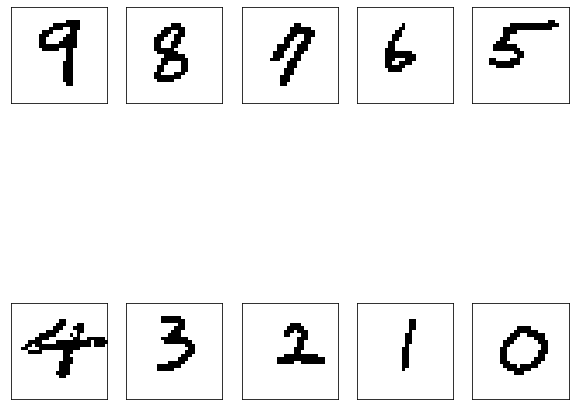

In [5]:
#세션 정보를 다시 불러오기 위한 코드
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
acc=0
saver = tf.train.Saver()
saver.restore(sess, "./saved/train1-4251")

#정상적으로 restore가 되었는지 확인하는 코드
p_sum=np.zeros([10000,10])
for i_2 in range(model_size):
  p=sess.run(models[i_2].p,feed_dict={models[i_2].x:mnist.test.images,
  models[i_2].t:mnist.test.labels,
  models[i_2].keep_prob:1.0,models[i_2].is_train:False})
  p_sum+=p
t=mnist.test.labels
correct_prediction = np.equal(np.argmax(p_sum, 1), np.argmax(t, 1))
acc_val=float(correct_prediction.astype(int).sum())/float(len(correct_prediction))
print ('Accuracy: %f'% (acc_val))

#get data from drive
import imageio
my_data=np.array(np.zeros([1,28,28]))
for i in range(10):
  temp=imageio.imread("/content/drive/My Drive/%d.png"%i)
  if(i==4):
    t_np=np.array(list(temp))
    t_np=t_np[:,:,0]+t_np[:,:,1]+t_np[:,:,2]+t_np[:,:,3]
    t_np=abs(252-t_np)
    for row in range(28):
      for col in range(28):
        if(t_np[row,col]>30):
          t_np[row,col]=1
        else:
          t_np[row,col]=0
  else:
    t_np=np.array(list(temp))
    t_np=abs(255-t_np)
    for row in range(28):
      for col in range(28):
        if(t_np[row,col]>30):
          t_np[row,col]=1
        else:
          t_np[row,col]=0
  t_np=t_np.reshape([1,28,28])
  my_data=np.vstack((t_np,my_data))
my_data=my_data[:-1]
fig = plt.figure(figsize=(10,10))
for i in range(10):
  subplot = fig.add_subplot(2,5, i+1)
  subplot.set_xticks([])
  subplot.set_yticks([])
  subplot.imshow(my_data[i],
  vmin=0, vmax=1,
  cmap=plt.cm.gray_r, interpolation='nearest')
fig.show()

#classify by trained-model
p_sum=np.zeros([10,10])
my_data=my_data.reshape([10,784])
for i_2 in range(model_size):
  p_val=sess.run(models[i_2].p,feed_dict={models[i_2].x:my_data,
  models[i_2].keep_prob:1.0,models[i_2].is_train:False})
  p_sum+=p_val
print("prediction : %s"%(np.argmax(p_sum,1)))
